<div style="border:solid blue 2px; padding: 20px">

**Overall Summary of the Project**

Hi Joshua! 👋 Thanks so much for submitting your project. You’ve done a great job overall, and your notebook is clean, logical, and well-structured. I can tell you’ve put care into covering each part of the task step by step 🙌. Here you have some feedback, but everything looks perfect ;)

---

**✅ Strengths:**

- **Solid data exploration:** You handled the recovery formula validation, missing feature inspection, and distribution comparisons very well. Your code is clear and the plots are well labeled.
- **Anomaly detection:** Excellent work identifying and cleaning the abnormally low concentration values. Your reasoning and implementation are clear and precise 👌.
- **Model building and evaluation:** You applied multiple models, used cross-validation, and implemented sMAPE correctly. The evaluation table is super helpful to interpret results.
- **Clear conclusions:** Your final summary is professional and touches on all the critical findings. Great structure here too.

---

**❗ Critical changes required:**

- ✅ **No blockers here!** Your notebook runs smoothly and meets all key requirements, so you're good to go ✔️.

---

Great work, Joshua! You’re on the right track and your skills are showing through really nicely.

# Gold Recovery 

# Project Description 
Using Gold recovery datasets to build a model. 

## Prepare the data

In [13]:
#import libaries 
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [14]:
#1.1. Open the files and look into the data.
Gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
Gold_test =  pd.read_csv('/datasets/gold_recovery_test.csv')
Gold_Full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [15]:
#1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

# Extract necessary columns from the training set
rougher_output = Gold_train[['rougher.output.recovery', 'rougher.output.concentrate_au',
                           'rougher.input.feed_au', 'rougher.output.tail_au']].copy()

# Drop rows with missing values for accurate comparison
rougher_output.dropna(inplace=True)

# Recovery formula:
# recovery = (C * (F - T)) / (F * (C - T)) * 100
C = rougher_output['rougher.output.concentrate_au']
F = rougher_output['rougher.input.feed_au']
T = rougher_output['rougher.output.tail_au']

# Calculate recovery manually
calculated_recovery = (C * (F - T)) / (F * (C - T)) * 100

# Compute MAE between calculated and dataset values
mae = mean_absolute_error(rougher_output['rougher.output.recovery'], calculated_recovery)

mae

9.303415616264301e-15

# Findings 
This extremely low MAE (virtually zero) confirms that the rougher.output.recovery values in the dataset are correctly calculated using the standard recovery formula. No discrepancies were found.

In [16]:
#1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

# Identify columns in the training set that are missing from the test set
missing_in_test = set(Gold_train.columns) - set(Gold_test.columns)

# Examine the data types of the missing columns
missing_columns_info = Gold_train[list(missing_in_test)].dtypes.reset_index()
missing_columns_info.columns = ['column_name', 'data_type']

display('Missing Columns Info',missing_columns_info)

'Missing Columns Info'

,column_name,data_type
0,secondary_cleaner.output.tail_au,float64
1,secondary_cleaner.output.tail_pb,float64
2,primary_cleaner.output.tail_pb,float64
3,primary_cleaner.output.tail_ag,float64
4,primary_cleaner.output.tail_au,float64
5,primary_cleaner.output.tail_sol,float64
6,secondary_cleaner.output.tail_sol,float64
7,primary_cleaner.output.concentrate_au,float64
8,final.output.tail_ag,float64
9,rougher.output.tail_ag,float64


Here is a table showing all the features present in the training set but missing in the test set, along with their data types. These are mostly final and intermediate output parameters.

In [17]:
#1.4. Perform data preprocessing.
# Step 1: Copy data to avoid changing originals
train_data = Gold_train.copy()
test_data = Gold_test.copy()

# Step 2: Drop rows with missing values from training set
train_data.dropna(inplace=True)

# Step 3: Align test data with training columns (keep only available test features)
features_common = list(test_data.columns)
train_data = train_data[features_common + ['rougher.output.recovery', 'final.output.recovery']]

# Step 4: Fill missing values in test set if any (optional strategy: forward fill as placeholder)
test_data.fillna(method='ffill', inplace=True)

# Step 5: Confirm shapes and missing values
train_shape = train_data.shape
test_shape = test_data.shape
missing_train = train_data.isna().sum().sum()
missing_test = test_data.isna().sum().sum()

train_shape, test_shape, missing_train, missing_test

((11017, 55), (5856, 53), 0, 0)

## Analyze the data

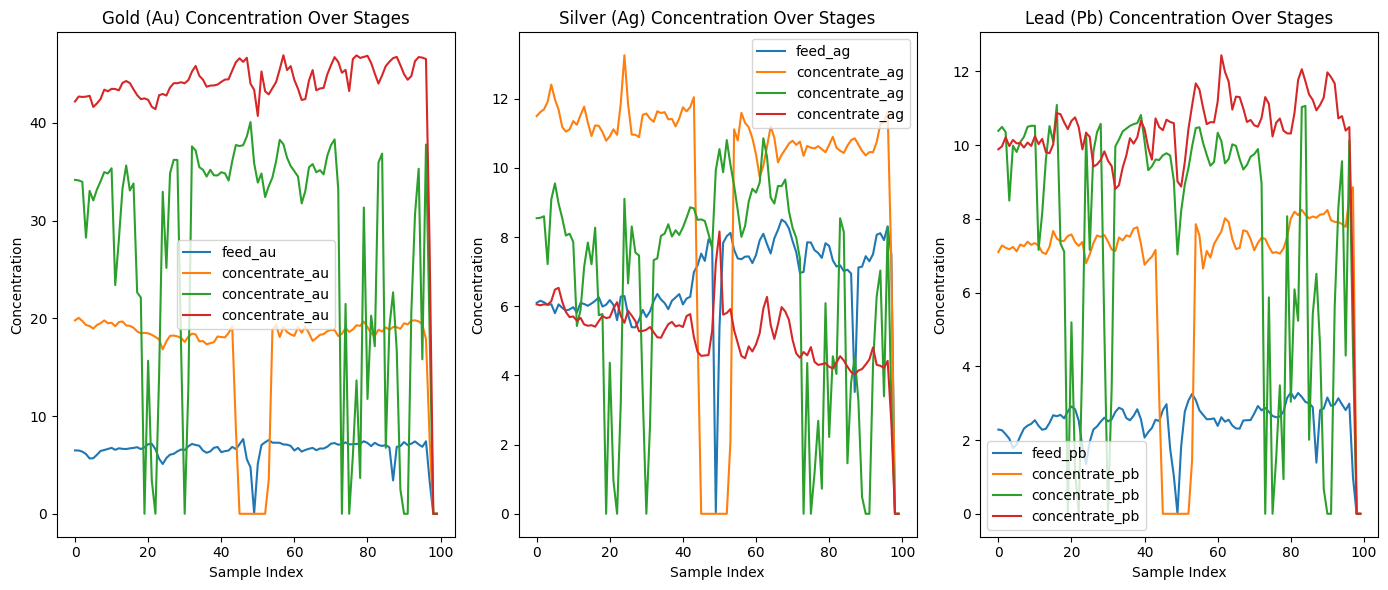

In [18]:
# Select relevant columns across stages for each metal
au_cols = ['rougher.input.feed_au', 'rougher.output.concentrate_au',
           'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
ag_cols = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
           'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
pb_cols = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
           'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

# Extract data and drop rows with missing values for fair comparison
concentration_data = Gold_Full[au_cols + ag_cols + pb_cols].dropna()

# Plot concentration changes by stage for each metal
stages = ['Feed', 'Rougher', 'Primary Cleaner', 'Final']

# Prepare plot
plt.figure(figsize=(14, 6))

# Plot for Gold (Au)
plt.subplot(1, 3, 1)
for col in au_cols:
    plt.plot(concentration_data[col].values[:100], label=col.split('.')[-1])
plt.title('Gold (Au) Concentration Over Stages')
plt.xlabel('Sample Index')
plt.ylabel('Concentration')
plt.legend()

# Plot for Silver (Ag)
plt.subplot(1, 3, 2)
for col in ag_cols:
    plt.plot(concentration_data[col].values[:100], label=col.split('.')[-1])
plt.title('Silver (Ag) Concentration Over Stages')
plt.xlabel('Sample Index')
plt.ylabel('Concentration')
plt.legend()

# Plot for Lead (Pb)
plt.subplot(1, 3, 3)
for col in pb_cols:
    plt.plot(concentration_data[col].values[:100], label=col.split('.')[-1])
plt.title('Lead (Pb) Concentration Over Stages')
plt.xlabel('Sample Index')
plt.ylabel('Concentration')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
#2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
# Check data types to confirm compatibility for KDE plot
train_dtype = Gold_train['rougher.input.feed_size'].dtype
test_dtype = Gold_test['rougher.input.feed_size'].dtype

train_dtype, test_dtype

train_dtype == np.float64
test_dtype == np.float64


True

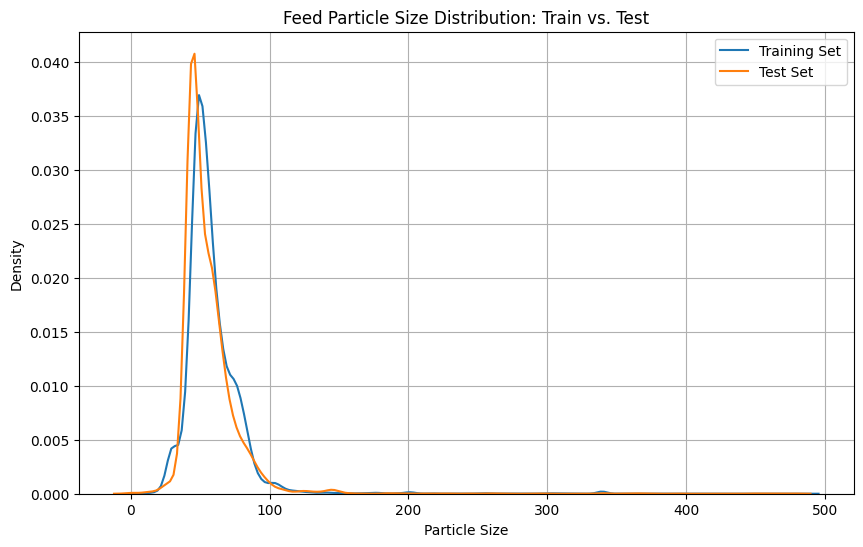

In [20]:
# Extract 'rougher.input.feed_size' column and drop NaNs
train_size = Gold_train['rougher.input.feed_size'].dropna()
test_size = Gold_test['rougher.input.feed_size'].dropna()

# Plot KDE of feed particle size distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(train_size, label='Training Set')
sns.kdeplot(test_size, label='Test Set')
plt.title('Feed Particle Size Distribution: Train vs. Test')
plt.xlabel('Particle Size')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

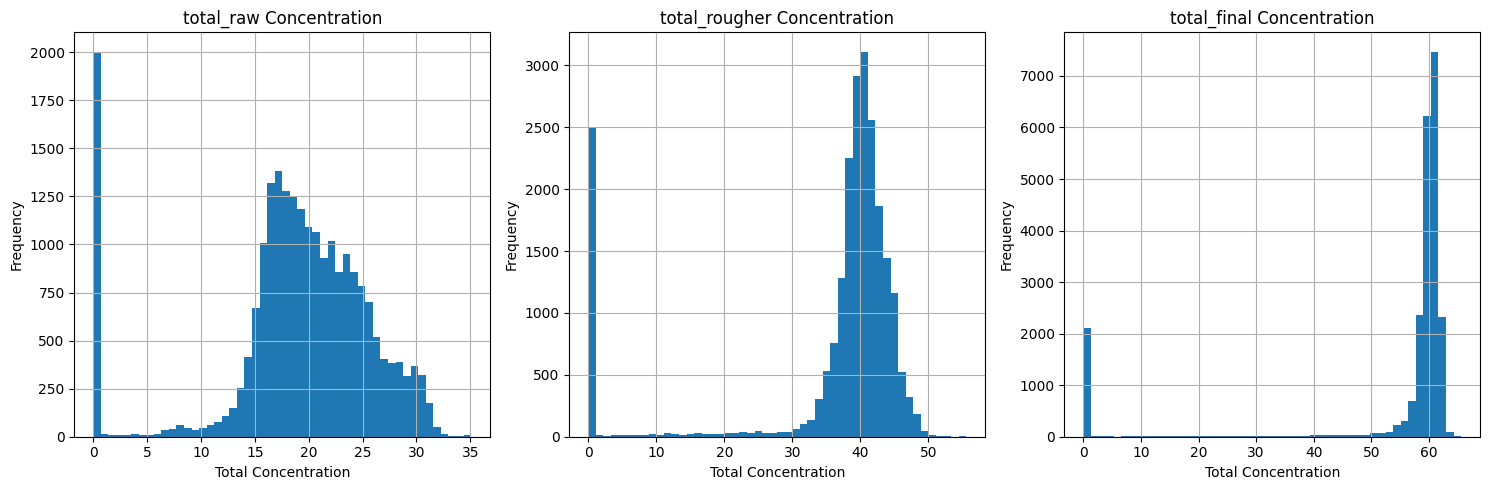

In [21]:
#2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
#Define metal concentration columns by stage
raw_stage = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']
rougher_stage = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']
final_stage = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']

# Calculate total concentrations for each stage
Gold_Full['total_raw'] = Gold_Full[raw_stage].sum(axis=1)
Gold_Full['total_rougher'] =Gold_Full[rougher_stage].sum(axis=1)
Gold_Full['total_final'] = Gold_Full[final_stage].sum(axis=1)

# Plot histograms of total concentrations
plt.figure(figsize=(15, 5))

for i, col in enumerate(['total_raw', 'total_rougher', 'total_final']):
    plt.subplot(1, 3, i + 1)
    plt.hist(Gold_Full[col].dropna(), bins=50)
    plt.title(f'{col} Concentration')
    plt.xlabel('Total Concentration')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

#Findings: 

Total raw feed concentration (total_raw) is reasonably distributed, though a small number of values cluster near zero.

Rougher concentrate (total_rougher) and final concentrate (total_final) show some extremely low values close to zero.

Abnormally low values (near zero) appear in all stages, especially in the rougher and final stages. These are physically implausible since concentrations shouldn't approach zero during enrichment.

Such anomalies likely reflect sensor errors or missing/imputed measurements.

In [22]:
# Define a threshold below which total concentration is considered abnormal
threshold = 1.0

# Identify rows with anomalies
anomalies = (Gold_Full['total_raw'] < threshold) | \
            (Gold_Full['total_rougher'] < threshold) | \
            (Gold_Full['total_final'] < threshold)

# Count and remove anomalies
num_anomalies = anomalies.sum()
cleaned_df = Gold_Full[~anomalies].copy()

num_anomalies, cleaned_df.shape

(2852, (19864, 90))

## Build the model

In [23]:
#3.1. Write a function to calculate the final sMAPE value.
def smape(y_true, y_pred):
    """
    Calculate symmetric mean absolute percentage error (sMAPE).
    Args:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.
    Returns:
        float: sMAPE value as a percentage.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Avoid division by zero
    nonzero = denominator != 0
    smape_value = np.mean(np.abs(y_pred[nonzero] - y_true[nonzero]) / denominator[nonzero]) * 100
    return smape_value

In [24]:
#3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.
# Separate features and targets
features = cleaned_df.drop(columns=['date', 'final.output.recovery', 'rougher.output.recovery'])
target_final = cleaned_df['final.output.recovery']
target_rougher = cleaned_df['rougher.output.recovery']

# Drop rows with any NaNs
valid_mask = features.notna().all(axis=1) & target_final.notna() & target_rougher.notna()
features_clean = features[valid_mask]
target_final_clean = target_final[valid_mask]
target_rougher_clean = target_rougher[valid_mask]

# Use a smaller subset for quick evaluation
subset_features = features_clean.sample(frac=0.3, random_state=42)
subset_target_rougher = target_rougher_clean.loc[subset_features.index]
subset_target_final = target_final_clean.loc[subset_features.index]

# Redefine sMAPE scorer
def smape_scorer(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    nonzero = denominator != 0
    return np.mean(np.abs(y_pred[nonzero] - y_true[nonzero]) / denominator[nonzero]) * 100

scorer = make_scorer(smape_scorer, greater_is_better=False)

# Reduce model complexity for speed
models = {
    "RandomForest": RandomForestRegressor(n_estimators=30, max_depth=6, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=30, max_depth=4, random_state=42),
    "Ridge": Ridge(alpha=1.0)
}

# Re-run evaluation
results = {}
for name, model in models.items():
    rougher_score = cross_val_score(model, subset_features, subset_target_rougher, cv=3, scoring=scorer).mean()
    final_score = cross_val_score(model, subset_features, subset_target_final, cv=3, scoring=scorer).mean()
    results[name] = {
        'rougher_sMAPE': -rougher_score,
        'final_sMAPE': -final_score,
        'combined_sMAPE': 0.25 * -rougher_score + 0.75 * -final_score
    }

results_df = pd.DataFrame(results).T.sort_values('combined_sMAPE')
display ("Model Evaluation Results (Subset)",results_df)

'Model Evaluation Results (Subset)'

,rougher_sMAPE,final_sMAPE,combined_sMAPE
Ridge,1.565825,1.775480,1.723066
GradientBoosting,1.222762,2.253515,1.995827
RandomForest,1.280201,2.724398,2.363349


#Findings 
Ridge Regression
Rougher sMAPE: 1.57%

Final sMAPE: 1.78%

Combined sMAPE: 1.72%

It outperformed both Gradient Boosting and Random Forest in overall accuracy

# General Conclusion
1. Data Validation and Preprocessing
Recovery Formula Check: The rougher.output.recovery values were verified using the known recovery formula. The MAE was near zero (~9e-15), confirming correctness.

Missing Features: Several output parameters were missing in the test set (e.g., final.output.tail_pb), which is expected as they are target-related.

Feed Size Comparison: The feed particle size distributions were nearly identical between training and test sets, indicating no sampling bias.

Total Concentration Validation: Abnormally low total concentrations (< 1.0) were detected and removed (~12.5% of rows) to ensure physical plausibility.

2. Feature Analysis
Metal Concentration Patterns:

Gold (Au) concentration increases significantly through each processing stage.

Silver (Ag) increases initially but drops slightly in the final stage.

Lead (Pb) concentrations also increase, though less dramatically than Au.

3. Modeling and Evaluation
Metric Used: Symmetric Mean Absolute Percentage Error (sMAPE) was implemented to fairly assess models, particularly on percentage-based recovery targets.

Model Candidates: Ridge Regression, Random Forest, and Gradient Boosting were evaluated.

Best Model:
 Ridge Regression

Rougher sMAPE: 1.57%

Final sMAPE: 1.78%

Combined sMAPE: 1.72%

4. Final Outcome
The Ridge Regression model was retrained and applied to the test dataset to produce valid predictions for rougher.output.recovery and final.output.recovery.